In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data_path = "drive/My Drive/_data/"
!ls "drive/My Drive/"
!ls "drive/My Drive/_data"




import sys
sys.path.append('drive/My Drive/')

import pandas as pd

import unicodedata
import re

import nltk
nltk.download('treebank')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import word_tokenize


import os
import numpy as np
from keras.models import Sequential, Model
from keras.layers import *#Embedding,Bidirectional,Dense,Conv1D,Flatten,LSTM,GlobalMaxPooling1D,Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pickle

In [ ]:
data_file = data_path + "valid.tsv"
df_v = pd.read_csv(data_file, header=None, sep='\t', 
                 usecols=[1,2,8,9,10,11,12], 
                 names=['Label', 'Statement','F1','F2','F3','F4','F5'])
df_v = df_v.dropna() 

data_file = data_path + "test.tsv"
df_t = pd.read_csv(data_file, header=None, sep='\t', 
                 usecols=[1,2,8,9,10,11,12], 
                 names=['Label', 'Statement','F1','F2','F3','F4','F5'])
df_t = df_t.dropna()

data_file = data_path + "train.tsv"
df = pd.read_csv(data_file, header=None, sep='\t', 
                 usecols=[1,2,8,9,10,11,12], 
                 names=['Label', 'Statement','F1','F2','F3','F4','F5'])
df = df.dropna()

print(len(df))
print(len(df.columns))
print(df.columns)
print(df.Label.unique())
df.head()
# df['Statement'][0]

10238
7
Index(['Label', 'Statement', 'F1', 'F2', 'F3', 'F4', 'F5'], dtype='object')
['false' 'half-true' 'mostly-true' 'true' 'barely-true' 'pants-fire']


,Label,Statement,F1,F2,F3,F4,F5
0,false,Says the Annies List political group supports ...,0.0,1.0,0.0,0.0,0.0
1,half-true,When did the decline of coal start? It started...,0.0,0.0,1.0,1.0,0.0
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",70.0,71.0,160.0,163.0,9.0
3,false,Health care reform legislation is likely to ma...,7.0,19.0,3.0,5.0,44.0
4,half-true,The economic turnaround started at the end of ...,15.0,9.0,20.0,19.0,2.0


#preprocess

In [ ]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation_number(words):
    """Remove punctuation & number from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'([^\s\w]|_|[0-9])+', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

stop_words = set(stopwords.words("english"))
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation_number(words)
    # words = remove_stopwords(words)
    # words = stem_words(words)
    # words = lemmatize_verbs(words)
    return words

def norm_all_sent(_sentences):
  for _i,_w in enumerate(_sentences):
    # print(_i,_w)
    tmp_sentences = _w#_sentences[_w]
    tmp_sentences = word_tokenize(tmp_sentences)
    tmp_sentences = normalize(tmp_sentences)
    tmp_sentences = " ".join(tmp_sentences)
    _sentences[_i] = tmp_sentences
  return _sentences

def convert_labels(_label):
#['false' 'half-true' 'mostly-true' 'true' 'barely-true' 'pants-fire']  
    _label[_label=='false']=0
    _label[_label=='pants-fire']=0
    _label[_label=='half-true']=1
    _label[_label=='mostly-true']=1
    _label[_label=='barely-true']=0
    _label[_label=='true']=1
    return _label

In [ ]:
embed_num_dims = 100
max_seq_len = 100

sentences = df['Statement'].values
sentences = norm_all_sent(sentences)
Y = df['Label'].values
Y = convert_labels(Y).astype(np.int)


sentences_t = df_t['Statement'].values
sentences_t = norm_all_sent(sentences_t)
Y_t = df_t['Label'].values
Y_t = convert_labels(Y_t).astype(np.int)


sentences_v = df_v['Statement'].values
sentences_v = norm_all_sent(sentences_v)
Y_v = df_v['Label'].values
Y_v = convert_labels(Y_v).astype(np.int)


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
sequence = tokenizer.texts_to_sequences(sentences)
sequence_t = tokenizer.texts_to_sequences(sentences_t)
sequence_v = tokenizer.texts_to_sequences(sentences_v)

index_of_words = tokenizer.word_index
print("len(index_of_words)",len(index_of_words))

padded_seq = pad_sequences(sequence , maxlen = max_seq_len )
padded_seq_t = pad_sequences(sequence_t , maxlen = max_seq_len )
padded_seq_v = pad_sequences(sequence_v , maxlen = max_seq_len )

from keras.utils import to_categorical
Y = to_categorical(Y)
Y_t = to_categorical(Y_t)
Y_v = to_categorical(Y_v)

X_train=padded_seq
Y_train=Y
X_test=padded_seq_t
Y_test=Y_t
X_val=padded_seq_v
Y_val=Y_v


len(index_of_words) 12328


#CredRank Algorithm
##Measuring User Credibility in Social Media

In [ ]:
all_emb = df.iloc[:,2:].values
print("all_emb_train.shape=>",all_emb.shape)

all_emb_t = df_t.iloc[:,2:].values
print("all_emb_test.shape=>",all_emb_t.shape)

all_emb_v = df_v.iloc[:,2:].values
print("all_emb_valid.shape=>",all_emb_v.shape)


tmp_all_emb = np.concatenate((all_emb,all_emb_t,all_emb_v))
print("tmp_all_emb.shape=>",tmp_all_emb.shape)

all_emb_train.shape=> (10238, 5)
all_emb_test.shape=> (1267, 5)
all_emb_valid.shape=> (1284, 5)
tmp_all_emb.shape=> (12789, 5)


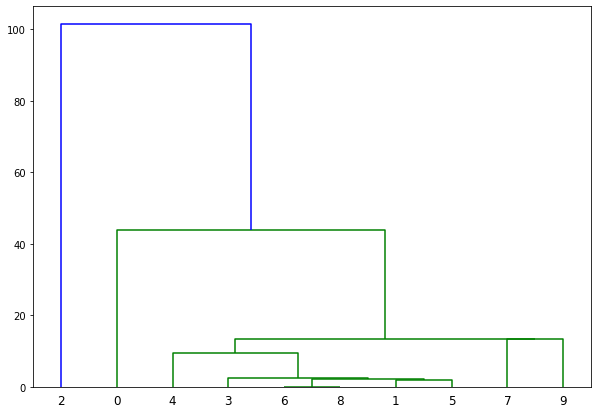

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(all_emb_t[:10,:], 'single')

plt.figure(figsize=(10, 7))
dendrogram (linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()


from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=100,affinity='euclidean', linkage='ward')# affinity="cosine", linkage='average')
tmp_c=cluster.fit_predict(tmp_all_emb)

# outfile = data_path + "clustering_result_new.npy"
# np.save(outfile, tmp_c)

In [ ]:
from collections import Counter

# data_file = data_path + "clustering_result_new.npy"
# tmp_c = np.load(data_file)


train_c = tmp_c[:len(all_emb)]
print(len(train_c))
print(np.unique(train_c))
print(Counter(train_c))
# print(Counter(Y_train.argmax(axis=1)))

test_c = tmp_c[len(all_emb):len(all_emb)+len(all_emb_t)]
print(len(test_c))
print(np.unique(test_c))
print(Counter(test_c))
# print(Counter(Y_train.argmax(axis=1)))

valid_c = tmp_c[len(all_emb)+len(all_emb_t):]
print(len(valid_c))
print(np.unique(valid_c))
print(Counter(valid_c))


n_of_m = Counter(train_c)
cluster_weight = np.zeros(len(n_of_m))
_tmp = np.array(list(n_of_m.values()))
_for_div = np.sum(np.sqrt(_tmp))
for _cluster in n_of_m:
    _c_i = np.sqrt(n_of_m[_cluster])
    # member_weight = np.sqrt(n_of_m[_cluster])/n_of_m[_cluster]
    cluster_weight[_cluster] = (_c_i/_for_div)#*member_weight


10238
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Counter({0: 713, 14: 681, 12: 556, 71: 488, 3: 400, 96: 368, 90: 337, 24: 289, 64: 273, 2: 257, 25: 239, 20: 221, 18: 187, 44: 176, 50: 158, 9: 158, 54: 149, 27: 148, 39: 142, 29: 142, 49: 128, 35: 122, 83: 117, 56: 115, 37: 103, 1: 102, 5: 98, 95: 93, 55: 88, 46: 82, 15: 79, 11: 78, 59: 78, 40: 78, 10: 77, 47: 72, 26: 71, 36: 70, 41: 70, 16: 69, 6: 69, 93: 69, 22: 68, 84: 65, 91: 63, 57: 63, 8: 61, 33: 59, 4: 57, 61: 56, 42: 56, 45: 55, 99: 52, 79: 49, 23: 49, 86: 49, 13: 48, 65: 46, 43: 46, 69: 46, 7: 44, 76: 44, 52: 43, 34: 43, 31: 42, 17: 42, 28: 42, 81: 39, 32: 38, 30: 37, 51: 37, 88: 37, 48: 37, 58: 36, 87: 35, 94: 35, 82: 34, 72: 34, 21: 32, 38: 32, 70: 31, 73: 31, 53: 30,

#Word Embedding

In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove*.zip
# !mv glove*.100d.txt 'drive/My Drive/_MrAnsari/_data'

f = open(data_path+'glove.6B.100d.txt')
embedd_index = {}
for line in f:
    val = line.split()
    word = val[0]
    coff = np.asarray(val[1:],dtype = 'float')
    embedd_index[word] = coff

f.close()
print('Found %s word vectors.' % len(embedd_index))

# a_file = open(data_path+"data.pkl", "wb")
# pickle.dump(embedd_index, a_file)
# a_file.close()

Found 400000 word vectors.


In [ ]:
# a_file = open(data_path+"data.pkl", "rb")
# output = pickle.load(a_file)
# print('Found %s word vectors.' % len(embedd_index))

embedd_index['good']

In [ ]:
embedding_matrix = np.zeros((len(index_of_words) + 1, embed_num_dims))

tokens = []
labels = []

for word,i in index_of_words.items():
    temp = embedd_index.get(word)
    if temp is not None:
        embedding_matrix[i] = temp
        
#for plotting
        tokens.append(embedding_matrix[i])
        labels.append(word)

print(embedding_matrix.shape)

(12329, 100)


In [ ]:
#TSNE algorithm used to visualize word embeddings having huge amount (100) dimensions

def tsne():
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens[:200])
    print(new_values.shape)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16,16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

    
    
    
    
tsne()

In [ ]:
from keras.optimizers import Adam

input1 = Input(shape=(max_seq_len,))
input2 = Input(shape=(1,))

#Embedding layer before the actaul BLSTM 
embedd_layer = Embedding(len(index_of_words) + 1 , 
                         embed_num_dims , 
                         input_length = max_seq_len , 
                         weights = [embedding_matrix])(input1)
BiLSTM = Bidirectional(LSTM(64 , return_sequences = True , dropout = 0.2 , recurrent_dropout = 0.2))(embedd_layer)
GMP = GlobalMaxPooling1D()(BiLSTM)
FC1 = Dense(32,activation = 'relu')(GMP)
FC1_d = Dropout(0.2)(FC1)
FC2 = Dense(2,activation = 'sigmoid')(FC1_d)
_newinput = Concatenate()([FC2, input2])
FC3 = Dense(2,activation = 'sigmoid')(_newinput)
model = Model(inputs=[input1, input2], outputs=FC3)
model.summary()

# _adam = Adam(lr = 0.01)
model.compile(loss = 'categorical_crossentropy' , optimizer = 'rmsprop' , metrics = ['accuracy'])


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 100)      1232900     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 50, 128)      84480       embedding[0][0]                  
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 128)          0           bidirectional[0][0]              
_______________________________________________________________________________________

In [ ]:
new_data = []
for _i in range(len(train_c)):
    tmp_data = cluster_weight[train_c[_i]]
    new_data.append(tmp_data)
new_data = np.array(new_data)

new_data_t = []
for _i in range(len(test_c)):
    tmp_data = cluster_weight[test_c[_i]]
    new_data_t.append(tmp_data)
new_data_t = np.array(new_data_t)

new_data_v = []
for _i in range(len(valid_c)):
    tmp_data = cluster_weight[valid_c[_i]]
    new_data_v.append(tmp_data)
new_data_v = np.array(new_data_v)



In [ ]:
hist = model.fit([X_train,new_data],Y_train,epochs = 10 , batch_size = 256, validation_data = ([X_val,new_data_v],Y_val))

result = model.evaluate([X_test,new_data_t],Y_test)
print(result[1]*100)

model_file = data_path + "LSTM_Model6_new_emb.h5"
model.save(model_file)

Epoch 1/10
40/40 [==============================] - 14s 359ms/step - loss: 0.6800 - accuracy: 0.5618 - val_loss: 0.6781 - val_accuracy: 0.5202
Epoch 2/10
40/40 [==============================] - 14s 354ms/step - loss: 0.6681 - accuracy: 0.5651 - val_loss: 0.6734 - val_accuracy: 0.5475
Epoch 3/10
40/40 [==============================] - 14s 351ms/step - loss: 0.6628 - accuracy: 0.5927 - val_loss: 0.6917 - val_accuracy: 0.5382
Epoch 4/10
40/40 [==============================] - 14s 345ms/step - loss: 0.6587 - accuracy: 0.6161 - val_loss: 0.6706 - val_accuracy: 0.6160
Epoch 5/10
40/40 [==============================] - 14s 351ms/step - loss: 0.6553 - accuracy: 0.6241 - val_loss: 0.6705 - val_accuracy: 0.6012
Epoch 6/10
40/40 [==============================] - 14s 341ms/step - loss: 0.6502 - accuracy: 0.6432 - val_loss: 0.6682 - val_accuracy: 0.6223
Epoch 7/10
40/40 [==============================] - 14s 350ms/step - loss: 0.6436 - accuracy: 0.6532 - val_loss: 0.6665 - val_accuracy: 0.6223

In [ ]:
model_file = data_path + "LSTM_Model6_new_emb.h5"
model.load_weights(model_file)

result = model.evaluate([X_test,new_data_t],Y_test)
print(result[1]*100)


40/40 [==============================] - 1s 24ms/step - loss: 0.6648 - accuracy: 0.5912
59.116023778915405


In [ ]:
#######################################
new_data = []
for _i in range(len(train_c)):
    tmp_data = cluster_weight[train_c[_i]]
    new_data.append(tmp_data)
new_data = np.array(new_data)

new_data_t = []
for _i in range(len(test_c)):
    tmp_data = cluster_weight[test_c[_i]]
    new_data_t.append(tmp_data)
new_data_t = np.array(new_data_t)

new_data_v = []
for _i in range(len(valid_c)):
    tmp_data = cluster_weight[valid_c[_i]]
    new_data_v.append(tmp_data)
new_data_v = np.array(new_data_v)
#######################################
#######################################

y_pred_v  = model.predict([X_val,new_data_v])
# print("Valid_Accuracy=>",np.mean((y_pred_v.argmax(axis=1)==Y_val.argmax(axis=1))))

y_pred_t  = model.predict([X_test,new_data_t])
# print("Test_Accuracy=>",np.mean((y_pred_t.argmax(axis=1)==Y_test.argmax(axis=1))))

y_pred  = model.predict([X_train,new_data])
# print("Train_Accuracy=>",np.mean((y_pred.argmax(axis=1)==Y_train.argmax(axis=1))))

new_data = []
for _i in range(y_pred.shape[0]):
    tmp_data = [cluster_weight[train_c[_i]],y_pred[_i,1]]
    new_data.append(tmp_data)
new_data = np.array(new_data)

new_data_t = []
for _i in range(y_pred_t.shape[0]):
    tmp_data = [cluster_weight[test_c[_i]],y_pred_t[_i,1]]
    new_data_t.append(tmp_data)
new_data_t = np.array(new_data_t)

new_data_v = []
for _i in range(y_pred_v.shape[0]):
    tmp_data = [cluster_weight[valid_c[_i]],y_pred_v[_i,1]]
    new_data_v.append(tmp_data)
new_data_v = np.array(new_data_v)


mode = 2
if mode == 0:
    new_train_data = new_data
    new_train_label = Y_train.argmax(axis=1)

    new_test_data = new_data_t
    new_test_label = Y_test.argmax(axis=1)

    print("New_Test_Accuracy=>",np.mean((y_pred_t.argmax(axis=1)==new_test_label)))

if mode == 1:
    new_train_data = new_data_t[:1500,:]
    new_train_label = Y_test.argmax(axis=1)[:1500]

    new_test_data = new_data_t[1500:,:]
    new_test_label = Y_test.argmax(axis=1)[1500:]

    print("New_Test_Accuracy=>",np.mean((y_pred_t.argmax(axis=1)[1500:]==new_test_label)))

if mode == 2:
    new_train_data = new_data_v
    new_train_label = Y_val.argmax(axis=1)

    new_test_data = new_data_t
    new_test_label = Y_test.argmax(axis=1)

    print("New_Test_Accuracy=>",np.mean((y_pred_t.argmax(axis=1)==new_test_label)))


New_Test_Accuracy=> 0.5911602209944752


In [ ]:
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.ensemble import RandomForestClassifier
clf1 = RandomForestClassifier(n_estimators=10, max_depth=None,
      min_samples_split=2, random_state=0)
clf1.fit(new_train_data, new_train_label)
y_pred = clf1.predict(new_test_data)
print("RandomForestClassifier ")
print('Confusion matrix(test):\n{}'.format(confusion_matrix(new_test_label, y_pred)))
print("Test_Accuracy=>",np.mean((y_pred==new_test_label)))
# print('f1-score=>(test):{}'.format(f1_score(new_test_label, y_pred)))


from sklearn.ensemble import ExtraTreesClassifier
clf2 = ExtraTreesClassifier(n_estimators=10, max_depth=None,
      min_samples_split=2, random_state=0)
clf2.fit(new_train_data, new_train_label)
y_pred = clf2.predict(new_test_data)
print("ExtraTreesClassifier")
print('Confusion matrix(test):\n{}'.format(confusion_matrix(new_test_label, y_pred)))
print("Test_Accuracy=>",np.mean((y_pred==new_test_label)))
# print('f1-score=>(test):{}'.format(f1_score(new_test_label, y_pred)))



from sklearn import svm
clf3 = svm.SVC()
clf3.fit(new_train_data, new_train_label)
y_pred = clf3.predict(new_test_data)
print("SVMClassifier")
print('Confusion matrix(test):\n{}'.format(confusion_matrix(new_test_label, y_pred)))
print("Test_Accuracy=>",np.mean((y_pred==new_test_label)))
# print('f1-score=>(test):{}'.format(f1_score(new_test_label, y_pred)))



from sklearn.neural_network import MLPClassifier
clf4 = MLPClassifier(random_state=1, max_iter=300).fit(new_train_data, new_train_label)
y_pred = clf4.predict(new_test_data)
print("MLPClassifier")
print('Confusion matrix(test):\n{}'.format(confusion_matrix(new_test_label, y_pred)))
print("Test_Accuracy=>",np.mean((y_pred==new_test_label)))
# print('f1-score=>(test):{}'.format(f1_score(new_test_label, y_pred)))


RandomForestClassifier 
Confusion matrix(test):
[[316 237]
 [339 375]]
Test_Accuracy=> 0.5453827940015785
ExtraTreesClassifier
Confusion matrix(test):
[[312 241]
 [337 377]]
Test_Accuracy=> 0.5438042620363063
SVMClassifier
Confusion matrix(test):
[[315 238]
 [274 440]]
Test_Accuracy=> 0.595895816890292
MLPClassifier
Confusion matrix(test):
[[315 238]
 [274 440]]
Test_Accuracy=> 0.595895816890292


#Final Test

In [ ]:
new_sentence_ori = ['Says the Annies List political group supports third-trimester abortions on demand.']
_emb_new_sentence = [1,13,12,14,3]
_emb_new_sentence = np.array(_emb_new_sentence).reshape(1, -1)
print("_emb_new_sentence.shape=>",_emb_new_sentence.shape)

new_sentence = norm_all_sent(new_sentence_ori)
print("1:new_sentence=>",new_sentence)
new_sentence = tokenizer.texts_to_sequences(new_sentence)
print("2:new_sentence=>",new_sentence)
new_sentence = pad_sequences(new_sentence , maxlen = max_seq_len)
print("3:new_sentence=>",new_sentence.shape)


from sklearn.metrics import euclidean_distances

_dist = euclidean_distances(_emb_new_sentence,all_emb)
_nearest_index = _dist.argmin()
_credit_rank = cluster_weight[train_c[_nearest_index]]
_credit_rank = _credit_rank.reshape(1)
print("_credit_rank.shape=>",_credit_rank.shape)

y_pred_new_sentence = model.predict([new_sentence,_credit_rank])
from scipy.special import softmax
y_pred_new_sentence = softmax(y_pred_new_sentence)

class_new_sentence = y_pred_new_sentence.argmax()
label_dict = ['false','true']

print("******************")
print("******************")
print("Classificatin Results:")
for _i in range(len(label_dict)):
    print("Class:",label_dict[_i],"=> probability:",y_pred_new_sentence[0][_i])
print("******************")
print("******************")
print("Final Result for statement==>>", new_sentence_ori[0])
print("Class:",label_dict[class_new_sentence],"=> probability:",y_pred_new_sentence[0][class_new_sentence])

new_data_for_next_step = np.array([y_pred_new_sentence[0][class_new_sentence],_credit_rank[0]])
new_data_for_next_step = new_data_for_next_step.reshape(1, -1)

print("******************")
print("##################")
print("******************")

y_pred = clf4.predict(new_data_for_next_step)
print("Result of second stage of Classification:")
print("Predicted Label:",label_dict[y_pred[0]])


_emb_new_sentence.shape=> (1, 5)
1:new_sentence=> ['says the annies list political group supports thirdtrimester abortions on demand']
2:new_sentence=> [[7, 1, 6734, 1045, 480, 565, 352, 4896, 541, 11, 1476]]
3:new_sentence=> (1, 50)
_credit_rank.shape=> (1,)
******************
******************
Classificatin Results:
Class: false => probability: 0.5205762
Class: true => probability: 0.4794238
******************
******************
Final Result for statement==>> says the annies list political group supports thirdtrimester abortions on demand
Class: false => probability: 0.5205762
******************
##################
******************
Result of second stage of Classification:
Predicted Label: false
